In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
!pip3 install jupyterthemes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchsummary import summary
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import os
import sys
from datetime import datetime
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, )),
    transforms.Resize((64, 64))
])

In [ ]:
dataset = torchvision.datasets.CIFAR10(root=".", transform=transform, 
                                            download=True)


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
if not os.path.exists("./IMAGES/"):
    os.mkdir("./IMAGES")

In [ ]:
def get_generator_block(input_channel, output_channel, kernel_size = 3, 
                        stride=2, padding=0, is_final_layer=False):
    
    """
    Description : Function to build the generator neural block

    Parameters:
    @param input_channel -- the number of input channels
    @param output_channel -- the number of output channels
    @param kernel_size -- the kernel size of the convolutional filter (default = 3)
    @param stride -- the window steps for the convolutional filter (default = 2)
    @param padding -- the amount of padding to apply (default = 0)
    @param is_final_layer -- bool value to determine if it is the final layer or not (by default=False)

    Return:
    @ret gen_block -- the neural block for the generator
    """

    gen_block = None

    if not is_final_layer:
        gen_block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, 
                               stride=stride, padding=padding, bias=False),

            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)

        )

    else:
        gen_block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, 
                               stride = stride, padding=padding, bias = False),
            
            nn.Tanh()
        )

    return gen_block

In [ ]:
def get_discriminator_block(input_channel, output_channel, kernel_size=3, 
                            stride=2, padding=0, use_batch_norm=None, 
                            is_final_layer= False):
    
    """
    Description : Function to build the discriminator neural block

    Parameters:
    @param input_channel -- the number of input channels
    @param output_channel -- the number of output channels
    @param kernel_size -- the convolutional filter size (default = 3)
    @param stride -- the window step for the convolutional filter size (default = 2)
    @param padding -- the amount of padding to be applied (default = 0)
    @param use_batch_norm -- bool value to determine whether to use BatchNormalization (default=True)
    @param is_final_layer -- bool value to determine whether it is the final layer (default=False)

    Return :
    @ret disc_block -- the discriminator block
    """

    disc_block = None

    if not is_final_layer and use_batch_norm:

        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, 
                      padding=padding, bias=False),

            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(negative_slope=0.2)
        )

    elif not is_final_layer and not use_batch_norm:
        
        disc_block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, 
                      padding=padding, bias=False),

            nn.LeakyReLU(negative_slope=0.2)
        )


    else:
        
        disc_block = nn.Sequential(nn.Conv2d(input_channel, output_channel, 
                                             kernel_size, stride=stride, 
                                             padding=padding, bias=False))
        
    
    return disc_block

In [ ]:
def get_noise(batch_size, latent_dim, device):

    """
    Description : Function to generate noise of size (batch_size x latent_dim)

    Parameters:
    @param batch_size -- the batch size or number of examples
    @param latent_dim -- the latent dimension for the noise vector
    @param device -- the device to use 

    Return:
    @ret noise -- the noise vector
    """

    noise = torch.randn(batch_size, latent_dim, device=device)
    return noise

In [ ]:
class Critic(nn.Module):
    
    def __init__(self, input_channel, hidden_channel = 64):

        super(Critic, self).__init__()

        self.disc = nn.Sequential(
            get_discriminator_block(input_channel, hidden_channel, 
                                    kernel_size=4, stride = 2, padding=1, 
                                    use_batch_norm=False),
            
            get_discriminator_block(hidden_channel, hidden_channel*2, 
                                    kernel_size=4, stride=2, padding=1),
                                  

            get_discriminator_block(hidden_channel*2, hidden_channel*4, 
                                    kernel_size=4, stride=2, padding=1),
                                  

            get_discriminator_block(hidden_channel*4, hidden_channel*8, 
                                    kernel_size=4, stride=2, padding=1),
            

            get_discriminator_block(hidden_channel*8, 1, 
                                    kernel_size=4, stride=1, padding=0, 
                                    is_final_layer=True)
            
        )

    def forward(self, im):
        return self.disc(im)

In [ ]:
class Generator(nn.Module):

    def __init__(self, input_channel, output_channel, hidden_channel=64):

        super(Generator, self).__init__()
        self.latent_dim = input_channel

        self.gen = nn.Sequential(
            get_generator_block(self.latent_dim, hidden_channel*8, kernel_size=4,
                                stride=1, padding=0),
                                 
            get_generator_block(hidden_channel*8, hidden_channel*4, kernel_size=4,
                                stride=2, padding=1),
                                 
            get_generator_block(hidden_channel*4, hidden_channel*2, kernel_size=4,
                                stride=2, padding=1),
                                 
            get_generator_block(hidden_channel*2, hidden_channel, kernel_size=4,
                                stride=2, padding=1),
                                 
            get_generator_block(hidden_channel, output_channel, kernel_size=4,
                                stride=2, padding=1, is_final_layer=True)
        )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.latent_dim, 1, 1)

    def forward(self, noise):
        noise = self.unsqueeze_noise(noise)
        return self.gen(noise)

In [ ]:
def init_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)

    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.normal_(m.bias, mean=0.0, std=1.0)


In [ ]:
def get_gradient(critic, real, fake, epsilon):

    """
    Description : Function to calculate the regularization value of the W-Loss

    Parameters:
    @param critic -- the critic network
    @param real -- Batch of real images
    @param fake -- Batch of fake images
    @param epsilon -- small value

    Return :
    @ret gradient -- the gradient of the critic's score enforced 1-L
    """

    mixed = real * epsilon + (1 - epsilon) * fake
    mixed_scores = critic(mixed)

    gradients = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=mixed,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True
    )[0]

    return gradients

In [ ]:
def calc_gradient_penalty(gradient):
    
    """
    Description : Function to calculate the gradient penalty for a given gradient

    Parameters:
    @param gradient -- the gradient of the critic's score

    Return :
    @ret penalty : the gradient penalty for the critic's score
    """

    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1) ** 2)

    return penalty

In [ ]:
def get_gen_loss(critic_fake_pred):

    """
    Description : Function to calculate the loss value for the generator

    Parameters : 
    @param critic_fake_pred -- the critic's score on the fake images

    Return :
    @ret gen_loss -- the loss function for the generator
    """

    gen_loss = -torch.mean(critic_fake_pred)
    return gen_loss

In [ ]:
def get_critic_loss(critic_real_pred, critic_fake_pred, gradient_penalty, 
                    regularization):
    
    """
    Description : Function to calculate the critic's loss function

    Parameters :
    @param critic_real_pred -- the critic's score on the real images
    @param critic_fake_pred -- the critic's score on the fake images
    @param gradient_penalty -- the gradient penalty on the critic's score
    @param regularization -- the regularization for the critic's score

    Return :
    @ret critic_loss -- the loss function for the critic_loss
    """

    critic_loss = -(torch.mean(critic_real_pred) - torch.mean(critic_fake_pred)) + gradient_penalty * regularization

    return critic_loss

In [ ]:
def train(index, flags):
    g_losses = []
    c_losses = []

    torch.manual_seed(flags['seed'])
    device = xm.xla_device()

    dataset = flags['dataset']

    sampler = torch.utils.data.distributed.DistributedSampler(dataset, 
                                                              num_replicas = xm.xrt_world_size(),
                                                              rank = xm.get_ordinal(),
                                                              shuffle=True)
    
    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=flags['batch_size'],
                                              sampler=sampler, 
                                              num_workers=flags['num_workers'],
                                              drop_last=True)
    
    G = Generator(flags['latent_dim'], flags['num_channels'])
    C = Critic(flags['num_channels'])

    G = G.to(device)
    C = C.to(device)

    g_optim = torch.optim.Adam(G.parameters(), lr=1e-4*2, betas=(0.5, 0.999))
    c_optim = torch.optim.Adam(C.parameters(), lr=1e-4*2, betas=(0.5, 0.999))
    critic_repeats = flags['crit_repeats']

    for epoch in range(flags['epochs']):

        t0 = datetime.now()
        para_loader = pl.ParallelLoader(data_loader, [device]).per_device_loader(device)
        g_loss = []
        c_loss = []
        cur_batch_size = 0

        for batch in tqdm(para_loader):
            data, _ = batch
            data = data.to(device)
            cur_batch_size = data.size(0)

            ###################################################
            ############# TRAIN DISCRIMINATOR #################
            ###################################################
            cLoss = []
            for _ in range(critic_repeats):

                c_optim.zero_grad()

                noise = get_noise(cur_batch_size, flags['latent_dim'], device)
                fake_img = G(noise).detach()

                critic_fake_pred = C(fake_img)
                critic_real_pred = C(data)

                epsilon = torch.rand(len(data), 1, 1, 1, device=device, requires_grad=True)
                gradient = get_gradient(C, data, fake_img, epsilon)
                gradient_penalty = calc_gradient_penalty(gradient)

                _cLoss = get_critic_loss(critic_real_pred, critic_fake_pred, gradient_penalty, flags['lambda'])

                cLoss.append(_cLoss.item())
                _cLoss.backward()
                xm.optimizer_step(c_optim)

            
            c_loss.append(np.mean(cLoss))



            ###################################################
            ############### TRAIN GENERATOR ###################
            ###################################################

            g_optim.zero_grad()

            noise = get_noise(cur_batch_size, flags['latent_dim'], device)
            fake_img = G(noise)

            critic_fake_pred = C(fake_img)
            gLoss = get_gen_loss(critic_fake_pred)
            g_loss.append(gLoss.item())
            
            gLoss.backward()
            xm.optimizer_step(g_optim)

        g_loss = np.mean(g_loss)
        c_loss = np.mean(c_loss)

        g_losses.append(g_loss)
        c_losses.append(c_loss)

        print(f"Epoch : {epoch+1}/{flags['epochs']} || Critic Loss : {c_loss} || Generator Loss : {g_loss} || Worker : {index} || Completetion Time : {datetime.now() - t0}")

        if flags['save'] and (epoch+ 1) % 10 == 0:
            
            noise = get_noise(cur_batch_size, flags['latent_dim'], device)
            fake_img = G(noise)
            save_image(fake_img, f"./IMAGES/WGAN_{epoch + 1}.png", normalize=True)


    return g_losses, c_losses, G, C



In [ ]:
flags = {
    "num_workers" : 8,
    "batch_size" : 128,
    "epochs" : 50,
    "latent_dim" : 100,
    "num_channels" : 3,
    "seed" : 1234,
    "dataset" : dataset,
    "crit_repeats" : 5,
    "lambda" : 10,
    "save" : True
}

In [ ]:
g_losses, d_losses, G, C = xmp.spawn(train, args=(flags,), nprocs=8, start_method='fork')




Epoch : 1/50 || Critic Loss : -59.20930844545365 || Generator Loss : 33.5454376625518 || Worker : 5 || Completetion Time : 0:04:58.559915

Epoch : 1/50 || Critic Loss : -59.08720927238465 || Generator Loss : 33.5454376625518 || Worker : 1 || Completetion Time : 0:04:56.210346

Epoch : 1/50 || Critic Loss : -59.38937537670136 || Generator Loss : 33.5454376625518 || Worker : 0 || Completetion Time : 0:05:05.405232


Epoch : 1/50 || Critic Loss : -59.19410952329636 || Generator Loss : 33.5454376625518 || Worker : 4 || Completetion Time : 0:05:02.522973
Epoch : 1/50 || Critic Loss : -58.84083317120869 || Generator Loss : 33.5454376625518 || Worker : 2 || Completetion Time : 0:05:02.576459
Epoch : 1/50 || Critic Loss : -59.17317637602488 || Generator Loss : 33.5454376625518 || Worker : 7 || Completetion Time : 0:05:02.892059
Epoch : 1/50 || Critic Loss : -58.90670026143391 || Generator Loss : 33.5454376625518 || Worker : 6 || Completetion Time : 0:04:57.472211

Epoch : 1/50 || Critic Los



Epoch : 2/50 || Critic Loss : -24.74341672261556 || Generator Loss : 6.5385109931230545 || Worker : 1 || Completetion Time : 0:01:13.002627

Epoch : 2/50 || Critic Loss : -24.84203244050344 || Generator Loss : 6.5385109931230545 || Worker : 5 || Completetion Time : 0:01:13.027089

Epoch : 2/50 || Critic Loss : -24.689343047142028 || Generator Loss : 6.5385109931230545 || Worker : 4 || Completetion Time : 0:01:12.992493

Epoch : 2/50 || Critic Loss : -24.612941050529482 || Generator Loss : 6.5385109931230545 || Worker : 0 || Completetion Time : 0:01:13.030971

Epoch : 2/50 || Critic Loss : -24.726295653978983 || Generator Loss : 6.5385109931230545 || Worker : 7 || Completetion Time : 0:01:13.019949

Epoch : 2/50 || Critic Loss : -24.793548242251077 || Generator Loss : 6.5385109931230545 || Worker : 2 || Completetion Time : 0:01:13.060714

Epoch : 2/50 || Critic Loss : -24.775506909688318 || Generator Loss : 6.5385109931230545 || Worker : 3 || Completetion Time : 0:01:13.016359
Epoch :




Epoch : 3/50 || Critic Loss : -15.902211344242096 || Generator Loss : 6.714740787943204 || Worker : 7 || Completetion Time : 0:01:12.729994
Epoch : 3/50 || Critic Loss : -15.969065646330515 || Generator Loss : 6.714740787943204 || Worker : 2 || Completetion Time : 0:01:12.713207
Epoch : 3/50 || Critic Loss : -15.916413438320157 || Generator Loss : 6.714740787943204 || Worker : 3 || Completetion Time : 0:01:12.683841


Epoch : 3/50 || Critic Loss : -15.883443607886633 || Generator Loss : 6.714740787943204 || Worker : 1 || Completetion Time : 0:01:12.879597

Epoch : 3/50 || Critic Loss : -15.836991119384765 || Generator Loss : 6.714740787943204 || Worker : 5 || Completetion Time : 0:01:12.886429

Epoch : 3/50 || Critic Loss : -15.840283928314845 || Generator Loss : 6.714740787943204 || Worker : 6 || Completetion Time : 0:01:12.730747
Epoch : 3/50 || Critic Loss : -15.99452646970749 || Generator Loss : 6.714740787943204 || Worker : 4 || Completetion Time : 0:01:12.919823

Epoch : 3/50 


Epoch : 4/50 || Critic Loss : -13.771950093905133 || Generator Loss : 4.430110996433844 || Worker : 1 || Completetion Time : 0:01:13.734025

Epoch : 4/50 || Critic Loss : -13.795122579733532 || Generator Loss : 4.430110996433844 || Worker : 7 || Completetion Time : 0:01:13.917285

Epoch : 4/50 || Critic Loss : -13.699145090579988 || Generator Loss : 4.430110996433844 || Worker : 5 || Completetion Time : 0:01:13.844704

Epoch : 4/50 || Critic Loss : -13.657654774188993 || Generator Loss : 4.430110996433844 || Worker : 6 || Completetion Time : 0:01:13.847386


Epoch : 4/50 || Critic Loss : -13.834823991854984 || Generator Loss : 4.430110996433844 || Worker : 4 || Completetion Time : 0:01:13.857407
Epoch : 4/50 || Critic Loss : -13.709078256289162 || Generator Loss : 4.430110996433844 || Worker : 0 || Completetion Time : 0:01:13.811025

Epoch : 4/50 || Critic Loss : -13.647131766875583 || Generator Loss : 4.430110996433844 || Worker : 3 || Completetion Time : 0:01:14.106512

Epoch : 4/50



Epoch : 5/50 || Critic Loss : -13.211492902040481 || Generator Loss : 3.8060716514786086 || Worker : 5 || Completetion Time : 0:01:13.349505
Epoch : 5/50 || Critic Loss : -13.27381269733111 || Generator Loss : 3.8060716514786086 || Worker : 0 || Completetion Time : 0:01:13.266550

Epoch : 5/50 || Critic Loss : -13.339392817020416 || Generator Loss : 3.8060716514786086 || Worker : 6 || Completetion Time : 0:01:13.359924

Epoch : 5/50 || Critic Loss : -13.379726330439249 || Generator Loss : 3.8060716514786086 || Worker : 2 || Completetion Time : 0:01:13.101039


Epoch : 5/50 || Critic Loss : -13.231563717126846 || Generator Loss : 3.8060716514786086 || Worker : 3 || Completetion Time : 0:01:13.238953
Epoch : 5/50 || Critic Loss : -13.3442109366258 || Generator Loss : 3.8060716514786086 || Worker : 4 || Completetion Time : 0:01:13.385053


Epoch : 5/50 || Critic Loss : -13.388155587514241 || Generator Loss : 3.8060716514786086 || Worker : 7 || Completetion Time : 0:01:13.512581
Epoch : 


Epoch : 6/50 || Critic Loss : -12.74576806227366 || Generator Loss : 2.852613230856756 || Worker : 0 || Completetion Time : 0:01:13.990818


Epoch : 6/50 || Critic Loss : -12.814711328347522 || Generator Loss : 2.852613230856756 || Worker : 4 || Completetion Time : 0:01:13.918717

Epoch : 6/50 || Critic Loss : -12.783126990000406 || Generator Loss : 2.852613230856756 || Worker : 7 || Completetion Time : 0:01:13.849855

Epoch : 6/50 || Critic Loss : -12.734988693396252 || Generator Loss : 2.852613230856756 || Worker : 5 || Completetion Time : 0:01:14.052587
Epoch : 6/50 || Critic Loss : -12.644697427749634 || Generator Loss : 2.852613230856756 || Worker : 3 || Completetion Time : 0:01:13.983493


Epoch : 6/50 || Critic Loss : -12.758429062366487 || Generator Loss : 2.852613230856756 || Worker : 6 || Completetion Time : 0:01:14.072458

Epoch : 6/50 || Critic Loss : -12.807454991340636 || Generator Loss : 2.852613230856756 || Worker : 1 || Completetion Time : 0:01:13.915708
Epoch : 6/50 


Epoch : 7/50 || Critic Loss : -12.281036253770191 || Generator Loss : 3.525804129351551 || Worker : 7 || Completetion Time : 0:01:14.977447

Epoch : 7/50 || Critic Loss : -12.183023128906887 || Generator Loss : 3.525804129351551 || Worker : 5 || Completetion Time : 0:01:14.981555

Epoch : 7/50 || Critic Loss : -12.235620508591333 || Generator Loss : 3.525804129351551 || Worker : 1 || Completetion Time : 0:01:14.911642

Epoch : 7/50 || Critic Loss : -12.105594476064047 || Generator Loss : 3.525804129351551 || Worker : 3 || Completetion Time : 0:01:15.027118

Epoch : 7/50 || Critic Loss : -12.275065791606904 || Generator Loss : 3.525804129351551 || Worker : 2 || Completetion Time : 0:01:14.966693


Epoch : 7/50 || Critic Loss : -12.14060814579328 || Generator Loss : 3.525804129351551 || Worker : 0 || Completetion Time : 0:01:15.165749
Epoch : 7/50 || Critic Loss : -12.199643091360727 || Generator Loss : 3.525804129351551 || Worker : 6 || Completetion Time : 0:01:15.113547

Epoch : 7/50 



Epoch : 8/50 || Critic Loss : -11.582254701852799 || Generator Loss : 2.719698420415322 || Worker : 7 || Completetion Time : 0:01:18.590966
Epoch : 8/50 || Critic Loss : -11.49054910937945 || Generator Loss : 2.719698420415322 || Worker : 3 || Completetion Time : 0:01:18.507057

Epoch : 8/50 || Critic Loss : -11.630916424592337 || Generator Loss : 2.719698420415322 || Worker : 4 || Completetion Time : 0:01:18.235297


Epoch : 8/50 || Critic Loss : -11.437908657391867 || Generator Loss : 2.719698420415322 || Worker : 0 || Completetion Time : 0:01:18.510570
Epoch : 8/50 || Critic Loss : -11.60195783774058 || Generator Loss : 2.719698420415322 || Worker : 1 || Completetion Time : 0:01:18.648955

Epoch : 8/50 || Critic Loss : -11.498951745033265 || Generator Loss : 2.719698420415322 || Worker : 5 || Completetion Time : 0:01:18.701188


Epoch : 8/50 || Critic Loss : -11.558596950769422 || Generator Loss : 2.719698420415322 || Worker : 2 || Completetion Time : 0:01:18.710010
Epoch : 8/50 |



Epoch : 9/50 || Critic Loss : -10.313377896944681 || Generator Loss : 2.9393195789307356 || Worker : 4 || Completetion Time : 0:01:15.202524
Epoch : 9/50 || Critic Loss : -10.235154740015666 || Generator Loss : 2.9393195789307356 || Worker : 0 || Completetion Time : 0:01:15.178861


Epoch : 9/50 || Critic Loss : -10.239564416805903 || Generator Loss : 2.9393195789307356 || Worker : 5 || Completetion Time : 0:01:15.151777
Epoch : 9/50 || Critic Loss : -10.262481892108918 || Generator Loss : 2.9393195789307356 || Worker : 6 || Completetion Time : 0:01:15.016783

Epoch : 9/50 || Critic Loss : -10.255341855684916 || Generator Loss : 2.9393195789307356 || Worker : 1 || Completetion Time : 0:01:15.246906


Epoch : 9/50 || Critic Loss : -10.338898758093515 || Generator Loss : 2.9393195789307356 || Worker : 7 || Completetion Time : 0:01:15.396519
Epoch : 9/50 || Critic Loss : -10.229919111728668 || Generator Loss : 2.9393195789307356 || Worker : 2 || Completetion Time : 0:01:15.174298

Epoch



Epoch : 10/50 || Critic Loss : -9.597284799814224 || Generator Loss : 3.436828402802348 || Worker : 7 || Completetion Time : 0:01:16.022030
Epoch : 10/50 || Critic Loss : -9.564174181222915 || Generator Loss : 3.436828402802348 || Worker : 4 || Completetion Time : 0:01:16.189970



Epoch : 10/50 || Critic Loss : -9.456614963213603 || Generator Loss : 3.436828402802348 || Worker : 5 || Completetion Time : 0:01:16.168023
Epoch : 10/50 || Critic Loss : -9.529193705320358 || Generator Loss : 3.436828402802348 || Worker : 2 || Completetion Time : 0:01:16.010784

Epoch : 10/50 || Critic Loss : -9.383100254336993 || Generator Loss : 3.436828402802348 || Worker : 0 || Completetion Time : 0:01:16.202963
Epoch : 10/50 || Critic Loss : -9.44291246732076 || Generator Loss : 3.436828402802348 || Worker : 1 || Completetion Time : 0:01:16.126105


Epoch : 10/50 || Critic Loss : -9.504507648944854 || Generator Loss : 3.436828402802348 || Worker : 6 || Completetion Time : 0:01:16.193639
Epoch : 10/50


Epoch : 11/50 || Critic Loss : -8.927710038423537 || Generator Loss : 3.2290241830050945 || Worker : 6 || Completetion Time : 0:01:13.816300


Epoch : 11/50 || Critic Loss : -8.783643444379171 || Generator Loss : 3.2290241830050945 || Worker : 0 || Completetion Time : 0:01:13.861680

Epoch : 11/50 || Critic Loss : -8.93658669392268 || Generator Loss : 3.2290241830050945 || Worker : 7 || Completetion Time : 0:01:14.039270
Epoch : 11/50 || Critic Loss : -8.872264577945073 || Generator Loss : 3.2290241830050945 || Worker : 5 || Completetion Time : 0:01:14.213723

Epoch : 11/50 || Critic Loss : -8.865849395593008 || Generator Loss : 3.2290241830050945 || Worker : 3 || Completetion Time : 0:01:13.934226

Epoch : 11/50 || Critic Loss : -8.884370893239975 || Generator Loss : 3.2290241830050945 || Worker : 1 || Completetion Time : 0:01:14.081070


Epoch : 11/50 || Critic Loss : -8.920610225200654 || Generator Loss : 3.2290241830050945 || Worker : 2 || Completetion Time : 0:01:14.042406
Epoch 



Epoch : 12/50 || Critic Loss : -8.588706950346628 || Generator Loss : 3.252949452959001 || Worker : 2 || Completetion Time : 0:01:14.507207

Epoch : 12/50 || Critic Loss : -8.52997494141261 || Generator Loss : 3.252949452959001 || Worker : 5 || Completetion Time : 0:01:14.700765


Epoch : 12/50 || Critic Loss : -8.565677426258723 || Generator Loss : 3.252949452959001 || Worker : 1 || Completetion Time : 0:01:14.612402
Epoch : 12/50 || Critic Loss : -8.500966235001881 || Generator Loss : 3.252949452959001 || Worker : 0 || Completetion Time : 0:01:14.781636
Epoch : 12/50 || Critic Loss : -8.601424970229466 || Generator Loss : 3.252949452959001 || Worker : 4 || Completetion Time : 0:01:14.521954

Epoch : 12/50 || Critic Loss : -8.53542375365893 || Generator Loss : 3.252949452959001 || Worker : 3 || Completetion Time : 0:01:14.724985

Epoch : 12/50 || Critic Loss : -8.684327155351639 || Generator Loss : 3.252949452959001 || Worker : 7 || Completetion Time : 0:01:14.857141

Epoch : 12/50 



Epoch : 13/50 || Critic Loss : -8.039194320638975 || Generator Loss : 3.1089805106942854 || Worker : 6 || Completetion Time : 0:01:13.478565

Epoch : 13/50 || Critic Loss : -8.210283386707305 || Generator Loss : 3.1089805106942854 || Worker : 7 || Completetion Time : 0:01:13.591218

Epoch : 13/50 || Critic Loss : -8.092419110735257 || Generator Loss : 3.1089805106942854 || Worker : 3 || Completetion Time : 0:01:13.673696
Epoch : 13/50 || Critic Loss : -8.023229188720386 || Generator Loss : 3.1089805106942854 || Worker : 0 || Completetion Time : 0:01:13.734356


Epoch : 13/50 || Critic Loss : -8.137182573477427 || Generator Loss : 3.1089805106942854 || Worker : 4 || Completetion Time : 0:01:13.745493
Epoch : 13/50 || Critic Loss : -8.034619025389354 || Generator Loss : 3.1089805106942854 || Worker : 1 || Completetion Time : 0:01:13.783843

Epoch : 13/50 || Critic Loss : -8.078051400184632 || Generator Loss : 3.1089805106942854 || Worker : 2 || Completetion Time : 0:01:13.866871

Epoch


Epoch : 14/50 || Critic Loss : -7.955977368354797 || Generator Loss : 3.06849863488848 || Worker : 7 || Completetion Time : 0:01:14.913857

Epoch : 14/50 || Critic Loss : -7.822020846605301 || Generator Loss : 3.06849863488848 || Worker : 3 || Completetion Time : 0:01:14.913894

Epoch : 14/50 || Critic Loss : -7.882735049724579 || Generator Loss : 3.06849863488848 || Worker : 5 || Completetion Time : 0:01:14.710695


Epoch : 14/50 || Critic Loss : -7.910602500041326 || Generator Loss : 3.06849863488848 || Worker : 4 || Completetion Time : 0:01:14.896203
Epoch : 14/50 || Critic Loss : -7.867986706892649 || Generator Loss : 3.06849863488848 || Worker : 0 || Completetion Time : 0:01:14.955645


Epoch : 14/50 || Critic Loss : -7.871220562855402 || Generator Loss : 3.06849863488848 || Worker : 2 || Completetion Time : 0:01:14.932405

Epoch : 14/50 || Critic Loss : -7.8579585711161295 || Generator Loss : 3.06849863488848 || Worker : 1 || Completetion Time : 0:01:14.997893
Epoch : 14/50 || C



Epoch : 15/50 || Critic Loss : -7.568368510405222 || Generator Loss : 2.4111471188565097 || Worker : 5 || Completetion Time : 0:01:13.236167

Epoch : 15/50 || Critic Loss : -7.560215657949448 || Generator Loss : 2.4111471188565097 || Worker : 6 || Completetion Time : 0:01:13.076180

Epoch : 15/50 || Critic Loss : -7.483435646692911 || Generator Loss : 2.4111471188565097 || Worker : 0 || Completetion Time : 0:01:13.217967
Epoch : 15/50 || Critic Loss : -7.559413288036983 || Generator Loss : 2.4111471188565097 || Worker : 1 || Completetion Time : 0:01:13.139459


Epoch : 15/50 || Critic Loss : -7.655848817030589 || Generator Loss : 2.4111471188565097 || Worker : 7 || Completetion Time : 0:01:13.338013
Epoch : 15/50 || Critic Loss : -7.528511679172516 || Generator Loss : 2.4111471188565097 || Worker : 3 || Completetion Time : 0:01:13.357733

Epoch : 15/50 || Critic Loss : -7.603074769179027 || Generator Loss : 2.4111471188565097 || Worker : 4 || Completetion Time : 0:01:13.336988

Epoch


Epoch : 16/50 || Critic Loss : -7.229171484708786 || Generator Loss : 2.163778911655148 || Worker : 1 || Completetion Time : 0:01:15.663181


Epoch : 16/50 || Critic Loss : -7.405737676223119 || Generator Loss : 2.163778911655148 || Worker : 7 || Completetion Time : 0:01:15.681119

Epoch : 16/50 || Critic Loss : -7.2830965956052145 || Generator Loss : 2.163778911655148 || Worker : 6 || Completetion Time : 0:01:15.776934
Epoch : 16/50 || Critic Loss : -7.247742120424907 || Generator Loss : 2.163778911655148 || Worker : 5 || Completetion Time : 0:01:15.795167

Epoch : 16/50 || Critic Loss : -7.292992163697879 || Generator Loss : 2.163778911655148 || Worker : 4 || Completetion Time : 0:01:15.684498


Epoch : 16/50 || Critic Loss : -7.267181415359178 || Generator Loss : 2.163778911655148 || Worker : 3 || Completetion Time : 0:01:15.801354
Epoch : 16/50 || Critic Loss : -7.265526529153188 || Generator Loss : 2.163778911655148 || Worker : 2 || Completetion Time : 0:01:15.592080

Epoch : 16/


Epoch : 17/50 || Critic Loss : -7.101009839773179 || Generator Loss : 1.9940320948759716 || Worker : 3 || Completetion Time : 0:01:13.701067

Epoch : 17/50 || Critic Loss : -7.065111068884531 || Generator Loss : 1.9940320948759716 || Worker : 5 || Completetion Time : 0:01:13.827473

Epoch : 17/50 || Critic Loss : -7.011217159032821 || Generator Loss : 1.9940320948759716 || Worker : 6 || Completetion Time : 0:01:13.857083

Epoch : 17/50 || Critic Loss : -6.952624701460202 || Generator Loss : 1.9940320948759716 || Worker : 0 || Completetion Time : 0:01:13.545780

Epoch : 17/50 || Critic Loss : -6.998881381750107 || Generator Loss : 1.9940320948759716 || Worker : 2 || Completetion Time : 0:01:13.781360

Epoch : 17/50 || Critic Loss : -7.141728165745735 || Generator Loss : 1.9940320948759716 || Worker : 7 || Completetion Time : 0:01:13.967988

Epoch : 17/50 || Critic Loss : -6.980153280496597 || Generator Loss : 1.9940320948759716 || Worker : 1 || Completetion Time : 0:01:14.121092

Epoch




Epoch : 18/50 || Critic Loss : -6.965151301026343 || Generator Loss : 2.099658005249997 || Worker : 7 || Completetion Time : 0:01:13.631442
Epoch : 18/50 || Critic Loss : -6.829780997832617 || Generator Loss : 2.099658005249997 || Worker : 5 || Completetion Time : 0:01:13.763646

Epoch : 18/50 || Critic Loss : -6.880034387111664 || Generator Loss : 2.099658005249997 || Worker : 6 || Completetion Time : 0:01:13.740347

Epoch : 18/50 || Critic Loss : -6.928468780716261 || Generator Loss : 2.099658005249997 || Worker : 4 || Completetion Time : 0:01:13.476879
Epoch : 18/50 || Critic Loss : -6.841645550727844 || Generator Loss : 2.099658005249997 || Worker : 2 || Completetion Time : 0:01:13.718802

Epoch : 18/50 || Critic Loss : -6.877120331923166 || Generator Loss : 2.099658005249997 || Worker : 3 || Completetion Time : 0:01:13.868469

Epoch : 18/50 || Critic Loss : -6.881204267342885 || Generator Loss : 2.099658005249997 || Worker : 1 || Completetion Time : 0:01:13.683312

Epoch : 18/5


Epoch : 19/50 || Critic Loss : -6.5327855229377745 || Generator Loss : 1.7428776106486719 || Worker : 1 || Completetion Time : 0:01:13.769083

Epoch : 19/50 || Critic Loss : -6.563112255930901 || Generator Loss : 1.7428776106486719 || Worker : 3 || Completetion Time : 0:01:13.844542

Epoch : 19/50 || Critic Loss : -6.4778010169665015 || Generator Loss : 1.7428776106486719 || Worker : 6 || Completetion Time : 0:01:13.950788

Epoch : 19/50 || Critic Loss : -6.598152758677801 || Generator Loss : 1.7428776106486719 || Worker : 4 || Completetion Time : 0:01:13.968192

Epoch : 19/50 || Critic Loss : -6.630956899126371 || Generator Loss : 1.7428776106486719 || Worker : 7 || Completetion Time : 0:01:14.060794


Epoch : 19/50 || Critic Loss : -6.546390912930171 || Generator Loss : 1.7428776106486719 || Worker : 5 || Completetion Time : 0:01:14.121333

Epoch : 19/50 || Critic Loss : -6.544013280669849 || Generator Loss : 1.7428776106486719 || Worker : 2 || Completetion Time : 0:01:14.088039
Epo


Epoch : 20/50 || Critic Loss : -6.335856976111731 || Generator Loss : 1.790434824069962 || Worker : 1 || Completetion Time : 0:01:15.915939

Epoch : 20/50 || Critic Loss : -6.281196270386379 || Generator Loss : 1.790434824069962 || Worker : 2 || Completetion Time : 0:01:15.715298

Epoch : 20/50 || Critic Loss : -6.352442286411922 || Generator Loss : 1.790434824069962 || Worker : 7 || Completetion Time : 0:01:15.803959

Epoch : 20/50 || Critic Loss : -6.315275630354882 || Generator Loss : 1.790434824069962 || Worker : 3 || Completetion Time : 0:01:15.965637


Epoch : 20/50 || Critic Loss : -6.36702751715978 || Generator Loss : 1.790434824069962 || Worker : 4 || Completetion Time : 0:01:15.906973

Epoch : 20/50 || Critic Loss : -6.262273770570755 || Generator Loss : 1.790434824069962 || Worker : 5 || Completetion Time : 0:01:15.790426
Epoch : 20/50 || Critic Loss : -6.256333236893018 || Generator Loss : 1.790434824069962 || Worker : 0 || Completetion Time : 0:01:15.766491

Epoch : 20/50


Epoch : 21/50 || Critic Loss : -6.258579616745313 || Generator Loss : 1.6196149398650352 || Worker : 7 || Completetion Time : 0:01:15.115926


Epoch : 21/50 || Critic Loss : -6.242814253767332 || Generator Loss : 1.6196149398650352 || Worker : 3 || Completetion Time : 0:01:15.092446


Epoch : 21/50 || Critic Loss : -6.158593660593033 || Generator Loss : 1.6196149398650352 || Worker : 0 || Completetion Time : 0:01:15.154122
Epoch : 21/50 || Critic Loss : -6.197000687321027 || Generator Loss : 1.6196149398650352 || Worker : 2 || Completetion Time : 0:01:15.171681
Epoch : 21/50 || Critic Loss : -6.155146024624507 || Generator Loss : 1.6196149398650352 || Worker : 5 || Completetion Time : 0:01:15.187219


Epoch : 21/50 || Critic Loss : -6.26503208875656 || Generator Loss : 1.6196149398650352 || Worker : 4 || Completetion Time : 0:01:15.168028

Epoch : 21/50 || Critic Loss : -6.205046459039053 || Generator Loss : 1.6196149398650352 || Worker : 1 || Completetion Time : 0:01:15.265368
Epoch 



Epoch : 22/50 || Critic Loss : -6.116345612208048 || Generator Loss : 1.5633657060874004 || Worker : 2 || Completetion Time : 0:01:14.756345
Epoch : 22/50 || Critic Loss : -6.208814399441084 || Generator Loss : 1.5633657060874004 || Worker : 7 || Completetion Time : 0:01:14.854149


Epoch : 22/50 || Critic Loss : -6.176860357324283 || Generator Loss : 1.5633657060874004 || Worker : 5 || Completetion Time : 0:01:14.778645

Epoch : 22/50 || Critic Loss : -6.131289043029149 || Generator Loss : 1.5633657060874004 || Worker : 1 || Completetion Time : 0:01:14.706052
Epoch : 22/50 || Critic Loss : -6.172546904285748 || Generator Loss : 1.5633657060874004 || Worker : 3 || Completetion Time : 0:01:14.872442



Epoch : 22/50 || Critic Loss : -6.229496606190999 || Generator Loss : 1.5633657060874004 || Worker : 4 || Completetion Time : 0:01:14.810004
Epoch : 22/50 || Critic Loss : -6.054569072524706 || Generator Loss : 1.5633657060874004 || Worker : 6 || Completetion Time : 0:01:14.743660
Epoch


Epoch : 23/50 || Critic Loss : -5.945137083530426 || Generator Loss : 1.4098397220174472 || Worker : 2 || Completetion Time : 0:01:15.136230


Epoch : 23/50 || Critic Loss : -5.956442447006702 || Generator Loss : 1.4098397220174472 || Worker : 6 || Completetion Time : 0:01:15.027449
Epoch : 23/50 || Critic Loss : -5.981580480933189 || Generator Loss : 1.4098397220174472 || Worker : 5 || Completetion Time : 0:01:15.137816

Epoch : 23/50 || Critic Loss : -6.0259719034036 || Generator Loss : 1.4098397220174472 || Worker : 3 || Completetion Time : 0:01:15.139169


Epoch : 23/50 || Critic Loss : -6.011766824126243 || Generator Loss : 1.4098397220174472 || Worker : 4 || Completetion Time : 0:01:15.112372

Epoch : 23/50 || Critic Loss : -6.046171089013417 || Generator Loss : 1.4098397220174472 || Worker : 7 || Completetion Time : 0:01:15.265826

Epoch : 23/50 || Critic Loss : -5.983474683761597 || Generator Loss : 1.4098397220174472 || Worker : 0 || Completetion Time : 0:01:15.162525
Epoch :



Epoch : 24/50 || Critic Loss : -5.84507452150186 || Generator Loss : 1.6598158924219508 || Worker : 2 || Completetion Time : 0:01:16.948540

Epoch : 24/50 || Critic Loss : -5.840887442231178 || Generator Loss : 1.6598158924219508 || Worker : 6 || Completetion Time : 0:01:16.929055
Epoch : 24/50 || Critic Loss : -5.997553648551306 || Generator Loss : 1.6598158924219508 || Worker : 3 || Completetion Time : 0:01:16.898536

Epoch : 24/50 || Critic Loss : -5.994478405515353 || Generator Loss : 1.6598158924219508 || Worker : 7 || Completetion Time : 0:01:16.834516


Epoch : 24/50 || Critic Loss : -5.991368415951729 || Generator Loss : 1.6598158924219508 || Worker : 1 || Completetion Time : 0:01:16.804017

Epoch : 24/50 || Critic Loss : -5.937159835298856 || Generator Loss : 1.6598158924219508 || Worker : 0 || Completetion Time : 0:01:16.852953

Epoch : 24/50 || Critic Loss : -5.94194968889157 || Generator Loss : 1.6598158924219508 || Worker : 5 || Completetion Time : 0:01:17.060956
Epoch :


Epoch : 25/50 || Critic Loss : -5.876269369324048 || Generator Loss : 1.4551171564186614 || Worker : 1 || Completetion Time : 0:01:14.464365

Epoch : 25/50 || Critic Loss : -5.87875478764375 || Generator Loss : 1.4551171564186614 || Worker : 7 || Completetion Time : 0:01:14.539008

Epoch : 25/50 || Critic Loss : -5.8391387929519025 || Generator Loss : 1.4551171564186614 || Worker : 4 || Completetion Time : 0:01:14.416792


Epoch : 25/50 || Critic Loss : -5.792673134803773 || Generator Loss : 1.4551171564186614 || Worker : 2 || Completetion Time : 0:01:14.638705
Epoch : 25/50 || Critic Loss : -5.755849450826645 || Generator Loss : 1.4551171564186614 || Worker : 6 || Completetion Time : 0:01:14.649886


Epoch : 25/50 || Critic Loss : -5.828454237182935 || Generator Loss : 1.4551171564186614 || Worker : 0 || Completetion Time : 0:01:14.562393
Epoch : 25/50 || Critic Loss : -5.802280761798222 || Generator Loss : 1.4551171564186614 || Worker : 5 || Completetion Time : 0:01:14.558981

Epoch


Epoch : 26/50 || Critic Loss : -5.753197020292281 || Generator Loss : 1.7365966962339978 || Worker : 1 || Completetion Time : 0:01:16.623201


Epoch : 26/50 || Critic Loss : -5.810850817461808 || Generator Loss : 1.7365966962339978 || Worker : 3 || Completetion Time : 0:01:16.367958
Epoch : 26/50 || Critic Loss : -5.863332664966584 || Generator Loss : 1.7365966962339978 || Worker : 4 || Completetion Time : 0:01:16.604571

Epoch : 26/50 || Critic Loss : -5.783262623349825 || Generator Loss : 1.7365966962339978 || Worker : 6 || Completetion Time : 0:01:16.599907

Epoch : 26/50 || Critic Loss : -5.7578568845987315 || Generator Loss : 1.7365966962339978 || Worker : 0 || Completetion Time : 0:01:16.570387

Epoch : 26/50 || Critic Loss : -5.802401346961656 || Generator Loss : 1.7365966962339978 || Worker : 5 || Completetion Time : 0:01:16.569593

Epoch : 26/50 || Critic Loss : -5.847415657838186 || Generator Loss : 1.7365966962339978 || Worker : 2 || Completetion Time : 0:01:16.725031

Epoc



Epoch : 27/50 || Critic Loss : -5.743595218658448 || Generator Loss : 1.4417664978342752 || Worker : 7 || Completetion Time : 0:01:14.262911


Epoch : 27/50 || Critic Loss : -5.671759645144145 || Generator Loss : 1.4417664978342752 || Worker : 0 || Completetion Time : 0:01:14.461291
Epoch : 27/50 || Critic Loss : -5.699466248353322 || Generator Loss : 1.4417664978342752 || Worker : 1 || Completetion Time : 0:01:14.602885
Epoch : 27/50 || Critic Loss : -5.754298471411069 || Generator Loss : 1.4417664978342752 || Worker : 3 || Completetion Time : 0:01:14.561200

Epoch : 27/50 || Critic Loss : -5.700287862618764 || Generator Loss : 1.4417664978342752 || Worker : 5 || Completetion Time : 0:01:14.464757

Epoch : 27/50 || Critic Loss : -5.734447617332141 || Generator Loss : 1.4417664978342752 || Worker : 2 || Completetion Time : 0:01:14.466504

Epoch : 27/50 || Critic Loss : -5.732124443848927 || Generator Loss : 1.4417664978342752 || Worker : 4 || Completetion Time : 0:01:14.641462

Epoch



Epoch : 28/50 || Critic Loss : -5.779710795481999 || Generator Loss : 1.4980087333048384 || Worker : 7 || Completetion Time : 0:01:15.023452

Epoch : 28/50 || Critic Loss : -5.676287898421287 || Generator Loss : 1.4980087333048384 || Worker : 0 || Completetion Time : 0:01:14.996557
Epoch : 28/50 || Critic Loss : -5.64119057059288 || Generator Loss : 1.4980087333048384 || Worker : 6 || Completetion Time : 0:01:14.738413


Epoch : 28/50 || Critic Loss : -5.706980640689532 || Generator Loss : 1.4980087333048384 || Worker : 5 || Completetion Time : 0:01:15.006675

Epoch : 28/50 || Critic Loss : -5.694172540307046 || Generator Loss : 1.4980087333048384 || Worker : 2 || Completetion Time : 0:01:14.994775

Epoch : 28/50 || Critic Loss : -5.726741038759549 || Generator Loss : 1.4980087333048384 || Worker : 1 || Completetion Time : 0:01:15.076637
Epoch : 28/50 || Critic Loss : -5.7464358349641165 || Generator Loss : 1.4980087333048384 || Worker : 3 || Completetion Time : 0:01:15.099343

Epoch


Epoch : 29/50 || Critic Loss : -5.596502556403479 || Generator Loss : 1.6304606810833018 || Worker : 3 || Completetion Time : 0:01:15.833682

Epoch : 29/50 || Critic Loss : -5.57492187519868 || Generator Loss : 1.6304606810833018 || Worker : 2 || Completetion Time : 0:01:15.896516


Epoch : 29/50 || Critic Loss : -5.541102207203706 || Generator Loss : 1.6304606810833018 || Worker : 5 || Completetion Time : 0:01:15.957046
Epoch : 29/50 || Critic Loss : -5.636927781502405 || Generator Loss : 1.6304606810833018 || Worker : 7 || Completetion Time : 0:01:16.017394


Epoch : 29/50 || Critic Loss : -5.533504517873127 || Generator Loss : 1.6304606810833018 || Worker : 6 || Completetion Time : 0:01:16.017916
Epoch : 29/50 || Critic Loss : -5.527954810857774 || Generator Loss : 1.6304606810833018 || Worker : 0 || Completetion Time : 0:01:16.051300

Epoch : 29/50 || Critic Loss : -5.62058325111866 || Generator Loss : 1.6304606810833018 || Worker : 4 || Completetion Time : 0:01:15.685812

Epoch :



Epoch : 30/50 || Critic Loss : -5.504702328642209 || Generator Loss : 1.5398468511799972 || Worker : 6 || Completetion Time : 0:01:14.618006

Epoch : 30/50 || Critic Loss : -5.6643874953190485 || Generator Loss : 1.5398468511799972 || Worker : 1 || Completetion Time : 0:01:14.545617
Epoch : 30/50 || Critic Loss : -5.651908897360166 || Generator Loss : 1.5398468511799972 || Worker : 4 || Completetion Time : 0:01:14.598846


Epoch : 30/50 || Critic Loss : -5.547595098117988 || Generator Loss : 1.5398468511799972 || Worker : 5 || Completetion Time : 0:01:14.713882
Epoch : 30/50 || Critic Loss : -5.5879924948016795 || Generator Loss : 1.5398468511799972 || Worker : 2 || Completetion Time : 0:01:14.770242

Epoch : 30/50 || Critic Loss : -5.576860988636811 || Generator Loss : 1.5398468511799972 || Worker : 3 || Completetion Time : 0:01:14.801185


Epoch : 30/50 || Critic Loss : -5.6322647472222656 || Generator Loss : 1.5398468511799972 || Worker : 7 || Completetion Time : 0:01:14.763177
Ep


Epoch : 31/50 || Critic Loss : -5.547209199269614 || Generator Loss : 1.5905301983778675 || Worker : 7 || Completetion Time : 0:01:14.500072

Epoch : 31/50 || Critic Loss : -5.634061122934024 || Generator Loss : 1.5905301983778675 || Worker : 1 || Completetion Time : 0:01:14.461683

Epoch : 31/50 || Critic Loss : -5.568305041392644 || Generator Loss : 1.5905301983778675 || Worker : 4 || Completetion Time : 0:01:14.520715

Epoch : 31/50 || Critic Loss : -5.424282345175743 || Generator Loss : 1.5905301983778675 || Worker : 5 || Completetion Time : 0:01:14.471477


Epoch : 31/50 || Critic Loss : -5.480163589119911 || Generator Loss : 1.5905301983778675 || Worker : 0 || Completetion Time : 0:01:14.520010

Epoch : 31/50 || Critic Loss : -5.465241538484892 || Generator Loss : 1.5905301983778675 || Worker : 6 || Completetion Time : 0:01:14.605318
Epoch : 31/50 || Critic Loss : -5.555560489495595 || Generator Loss : 1.5905301983778675 || Worker : 2 || Completetion Time : 0:01:14.572952

Epoch



Epoch : 32/50 || Critic Loss : -5.5491972982883455 || Generator Loss : 1.511350438852484 || Worker : 1 || Completetion Time : 0:01:14.901784

Epoch : 32/50 || Critic Loss : -5.494777397314707 || Generator Loss : 1.511350438852484 || Worker : 3 || Completetion Time : 0:01:14.671646
Epoch : 32/50 || Critic Loss : -5.364343698819479 || Generator Loss : 1.511350438852484 || Worker : 0 || Completetion Time : 0:01:14.804525


Epoch : 32/50 || Critic Loss : -5.4558141787846886 || Generator Loss : 1.511350438852484 || Worker : 6 || Completetion Time : 0:01:14.803785
Epoch : 32/50 || Critic Loss : -5.522846481204032 || Generator Loss : 1.511350438852484 || Worker : 4 || Completetion Time : 0:01:14.940244


Epoch : 32/50 || Critic Loss : -5.469689592719078 || Generator Loss : 1.511350438852484 || Worker : 2 || Completetion Time : 0:01:14.816148

Epoch : 32/50 || Critic Loss : -5.481931244333585 || Generator Loss : 1.511350438852484 || Worker : 7 || Completetion Time : 0:01:15.057854
Epoch : 32


Epoch : 33/50 || Critic Loss : -5.4218373219172165 || Generator Loss : 1.2335204668343067 || Worker : 4 || Completetion Time : 0:01:15.296016



Epoch : 33/50 || Critic Loss : -5.472057476639748 || Generator Loss : 1.2335204668343067 || Worker : 3 || Completetion Time : 0:01:15.513889
Epoch : 33/50 || Critic Loss : -5.385234442353249 || Generator Loss : 1.2335204668343067 || Worker : 2 || Completetion Time : 0:01:15.447858
Epoch : 33/50 || Critic Loss : -5.371122130751609 || Generator Loss : 1.2335204668343067 || Worker : 0 || Completetion Time : 0:01:15.514710


Epoch : 33/50 || Critic Loss : -5.427346158027649 || Generator Loss : 1.2335204668343067 || Worker : 5 || Completetion Time : 0:01:15.396647
Epoch : 33/50 || Critic Loss : -5.341875785589218 || Generator Loss : 1.2335204668343067 || Worker : 6 || Completetion Time : 0:01:15.517129


Epoch : 33/50 || Critic Loss : -5.446656646331152 || Generator Loss : 1.2335204668343067 || Worker : 1 || Completetion Time : 0:01:15.611383
Epoc


Epoch : 34/50 || Critic Loss : -5.346092039346694 || Generator Loss : 1.1921697810757905 || Worker : 5 || Completetion Time : 0:01:14.503858


Epoch : 34/50 || Critic Loss : -5.33668965001901 || Generator Loss : 1.1921697810757905 || Worker : 4 || Completetion Time : 0:01:14.747917
Epoch : 34/50 || Critic Loss : -5.370775255560875 || Generator Loss : 1.1921697810757905 || Worker : 1 || Completetion Time : 0:01:14.504708


Epoch : 34/50 || Critic Loss : -5.393103512128195 || Generator Loss : 1.1921697810757905 || Worker : 7 || Completetion Time : 0:01:14.523495
Epoch : 34/50 || Critic Loss : -5.391869155565897 || Generator Loss : 1.1921697810757905 || Worker : 3 || Completetion Time : 0:01:14.679114


Epoch : 34/50 || Critic Loss : -5.3476003170013415 || Generator Loss : 1.1921697810757905 || Worker : 2 || Completetion Time : 0:01:14.711316
Epoch : 34/50 || Critic Loss : -5.2747289657592775 || Generator Loss : 1.1921697810757905 || Worker : 6 || Completetion Time : 0:01:14.698924

Epoc



Epoch : 35/50 || Critic Loss : -5.316161398092906 || Generator Loss : 1.379112952388823 || Worker : 7 || Completetion Time : 0:01:14.645073
Epoch : 35/50 || Critic Loss : -5.265256731708845 || Generator Loss : 1.379112952388823 || Worker : 2 || Completetion Time : 0:01:14.576663

Epoch : 35/50 || Critic Loss : -5.277277016639709 || Generator Loss : 1.379112952388823 || Worker : 5 || Completetion Time : 0:01:14.769694


Epoch : 35/50 || Critic Loss : -5.269076302647591 || Generator Loss : 1.379112952388823 || Worker : 6 || Completetion Time : 0:01:14.586617
Epoch : 35/50 || Critic Loss : -5.356798340876897 || Generator Loss : 1.379112952388823 || Worker : 4 || Completetion Time : 0:01:14.802680


Epoch : 35/50 || Critic Loss : -5.3361834247907 || Generator Loss : 1.379112952388823 || Worker : 3 || Completetion Time : 0:01:14.749334

Epoch : 35/50 || Critic Loss : -5.406893293062846 || Generator Loss : 1.379112952388823 || Worker : 1 || Completetion Time : 0:01:14.867933
Epoch : 35/50 


Epoch : 36/50 || Critic Loss : -5.298660359779994 || Generator Loss : 1.2409342726847779 || Worker : 4 || Completetion Time : 0:01:14.715367


Epoch : 36/50 || Critic Loss : -5.236906080444654 || Generator Loss : 1.2409342726847779 || Worker : 0 || Completetion Time : 0:01:14.612382
Epoch : 36/50 || Critic Loss : -5.217881185809771 || Generator Loss : 1.2409342726847779 || Worker : 6 || Completetion Time : 0:01:14.790616


Epoch : 36/50 || Critic Loss : -5.338773558537166 || Generator Loss : 1.2409342726847779 || Worker : 1 || Completetion Time : 0:01:14.686731

Epoch : 36/50 || Critic Loss : -5.26907318731149 || Generator Loss : 1.2409342726847779 || Worker : 2 || Completetion Time : 0:01:14.902763
Epoch : 36/50 || Critic Loss : -5.29990483323733 || Generator Loss : 1.2409342726847779 || Worker : 3 || Completetion Time : 0:01:14.789022

Epoch : 36/50 || Critic Loss : -5.276617072025934 || Generator Loss : 1.2409342726847779 || Worker : 7 || Completetion Time : 0:01:14.973636

Epoch :


Epoch : 37/50 || Critic Loss : -5.293929592768351 || Generator Loss : 1.391203047086795 || Worker : 3 || Completetion Time : 0:01:13.937868


Epoch : 37/50 || Critic Loss : -5.227313742041588 || Generator Loss : 1.391203047086795 || Worker : 7 || Completetion Time : 0:01:13.913909

Epoch : 37/50 || Critic Loss : -5.173017895221711 || Generator Loss : 1.391203047086795 || Worker : 0 || Completetion Time : 0:01:14.085394
Epoch : 37/50 || Critic Loss : -5.21006135692199 || Generator Loss : 1.391203047086795 || Worker : 2 || Completetion Time : 0:01:14.035891

Epoch : 37/50 || Critic Loss : -5.187891233960787 || Generator Loss : 1.391203047086795 || Worker : 6 || Completetion Time : 0:01:14.120621

Epoch : 37/50 || Critic Loss : -5.214610979954402 || Generator Loss : 1.391203047086795 || Worker : 4 || Completetion Time : 0:01:14.204289

Epoch : 37/50 || Critic Loss : -5.278297032912572 || Generator Loss : 1.391203047086795 || Worker : 1 || Completetion Time : 0:01:14.160129

Epoch : 37/50


Epoch : 38/50 || Critic Loss : -5.124667729934056 || Generator Loss : 1.4290153527011473 || Worker : 5 || Completetion Time : 0:01:14.084997

Epoch : 38/50 || Critic Loss : -5.13935027718544 || Generator Loss : 1.4290153527011473 || Worker : 6 || Completetion Time : 0:01:14.427104


Epoch : 38/50 || Critic Loss : -5.19745265742143 || Generator Loss : 1.4290153527011473 || Worker : 4 || Completetion Time : 0:01:14.419193
Epoch : 38/50 || Critic Loss : -5.209853464365005 || Generator Loss : 1.4290153527011473 || Worker : 7 || Completetion Time : 0:01:14.529897


Epoch : 38/50 || Critic Loss : -5.215568421284358 || Generator Loss : 1.4290153527011473 || Worker : 1 || Completetion Time : 0:01:14.427566
Epoch : 38/50 || Critic Loss : -5.183439468344052 || Generator Loss : 1.4290153527011473 || Worker : 2 || Completetion Time : 0:01:14.574775

Epoch : 38/50 || Critic Loss : -5.207918180028597 || Generator Loss : 1.4290153527011473 || Worker : 3 || Completetion Time : 0:01:14.679527

Epoch :



Epoch : 39/50 || Critic Loss : -5.159684216976166 || Generator Loss : 1.3385653920316447 || Worker : 4 || Completetion Time : 0:01:14.012277

Epoch : 39/50 || Critic Loss : -5.107874145110448 || Generator Loss : 1.3385653920316447 || Worker : 0 || Completetion Time : 0:01:13.680376

Epoch : 39/50 || Critic Loss : -5.1047833010554315 || Generator Loss : 1.3385653920316447 || Worker : 6 || Completetion Time : 0:01:14.068923
Epoch : 39/50 || Critic Loss : -5.193918398022652 || Generator Loss : 1.3385653920316447 || Worker : 1 || Completetion Time : 0:01:13.985085

Epoch : 39/50 || Critic Loss : -5.106273870666822 || Generator Loss : 1.3385653920316447 || Worker : 2 || Completetion Time : 0:01:13.973776


Epoch : 39/50 || Critic Loss : -5.259614649415017 || Generator Loss : 1.3385653920316447 || Worker : 3 || Completetion Time : 0:01:13.995570
Epoch : 39/50 || Critic Loss : -5.1565596759319305 || Generator Loss : 1.3385653920316447 || Worker : 7 || Completetion Time : 0:01:14.122548

Epo



Epoch : 40/50 || Critic Loss : -5.05199582974116 || Generator Loss : 1.060627769678831 || Worker : 7 || Completetion Time : 0:01:15.509975

Epoch : 40/50 || Critic Loss : -5.0516750822464624 || Generator Loss : 1.060627769678831 || Worker : 6 || Completetion Time : 0:01:15.637552
Epoch : 40/50 || Critic Loss : -5.064183147748312 || Generator Loss : 1.060627769678831 || Worker : 3 || Completetion Time : 0:01:15.563623



Epoch : 40/50 || Critic Loss : -5.065603383878867 || Generator Loss : 1.060627769678831 || Worker : 0 || Completetion Time : 0:01:15.681221
Epoch : 40/50 || Critic Loss : -5.007103373606999 || Generator Loss : 1.060627769678831 || Worker : 5 || Completetion Time : 0:01:15.507738
Epoch : 40/50 || Critic Loss : -5.083839585383733 || Generator Loss : 1.060627769678831 || Worker : 4 || Completetion Time : 0:01:15.701292

Epoch : 40/50 || Critic Loss : -5.053218193352222 || Generator Loss : 1.060627769678831 || Worker : 2 || Completetion Time : 0:01:15.645103

Epoch : 40/5



Epoch : 41/50 || Critic Loss : -5.005653420090675 || Generator Loss : 1.2951230686157942 || Worker : 0 || Completetion Time : 0:01:16.277195
Epoch : 41/50 || Critic Loss : -4.938484462102254 || Generator Loss : 1.2951230686157942 || Worker : 6 || Completetion Time : 0:01:16.312887

Epoch : 41/50 || Critic Loss : -5.044951253135999 || Generator Loss : 1.2951230686157942 || Worker : 1 || Completetion Time : 0:01:16.418863


Epoch : 41/50 || Critic Loss : -5.023014252384503 || Generator Loss : 1.2951230686157942 || Worker : 7 || Completetion Time : 0:01:16.588274
Epoch : 41/50 || Critic Loss : -4.994980968038241 || Generator Loss : 1.2951230686157942 || Worker : 3 || Completetion Time : 0:01:16.584259

Epoch : 41/50 || Critic Loss : -4.941496153672536 || Generator Loss : 1.2951230686157942 || Worker : 2 || Completetion Time : 0:01:16.362126

Epoch : 41/50 || Critic Loss : -5.036834764480591 || Generator Loss : 1.2951230686157942 || Worker : 4 || Completetion Time : 0:01:16.543556

Epoch


Epoch : 42/50 || Critic Loss : -4.977037214239439 || Generator Loss : 1.2282963916659355 || Worker : 6 || Completetion Time : 0:01:14.036504


Epoch : 42/50 || Critic Loss : -5.002653848131497 || Generator Loss : 1.2282963916659355 || Worker : 5 || Completetion Time : 0:01:13.855071
Epoch : 42/50 || Critic Loss : -5.0519842823346455 || Generator Loss : 1.2282963916659355 || Worker : 4 || Completetion Time : 0:01:13.942197

Epoch : 42/50 || Critic Loss : -5.018914497892062 || Generator Loss : 1.2282963916659355 || Worker : 3 || Completetion Time : 0:01:14.093550


Epoch : 42/50 || Critic Loss : -5.053538331389427 || Generator Loss : 1.2282963916659355 || Worker : 7 || Completetion Time : 0:01:14.165548
Epoch : 42/50 || Critic Loss : -5.044393396377564 || Generator Loss : 1.2282963916659355 || Worker : 2 || Completetion Time : 0:01:14.161443


Epoch : 42/50 || Critic Loss : -5.1188947747151055 || Generator Loss : 1.2282963916659355 || Worker : 1 || Completetion Time : 0:01:14.428811
Epo


Epoch : 43/50 || Critic Loss : -4.952898754676183 || Generator Loss : 1.3784070103429258 || Worker : 7 || Completetion Time : 0:01:14.306326

Epoch : 43/50 || Critic Loss : -4.8809231926997505 || Generator Loss : 1.3784070103429258 || Worker : 5 || Completetion Time : 0:01:14.470307

Epoch : 43/50 || Critic Loss : -4.9207572857538855 || Generator Loss : 1.3784070103429258 || Worker : 2 || Completetion Time : 0:01:14.332762

Epoch : 43/50 || Critic Loss : -4.970781597495079 || Generator Loss : 1.3784070103429258 || Worker : 4 || Completetion Time : 0:01:14.496481

Epoch : 43/50 || Critic Loss : -5.0007003247737885 || Generator Loss : 1.3784070103429258 || Worker : 3 || Completetion Time : 0:01:14.486959


Epoch : 43/50 || Critic Loss : -5.012920730312665 || Generator Loss : 1.3784070103429258 || Worker : 1 || Completetion Time : 0:01:14.238476
Epoch : 43/50 || Critic Loss : -4.914761033654213 || Generator Loss : 1.3784070103429258 || Worker : 0 || Completetion Time : 0:01:14.272067

Ep



Epoch : 44/50 || Critic Loss : -4.833419379591942 || Generator Loss : 1.3543722070753574 || Worker : 1 || Completetion Time : 0:01:14.318596


Epoch : 44/50 || Critic Loss : -4.837956345081329 || Generator Loss : 1.3543722070753574 || Worker : 2 || Completetion Time : 0:01:14.445030
Epoch : 44/50 || Critic Loss : -4.883327733476957 || Generator Loss : 1.3543722070753574 || Worker : 3 || Completetion Time : 0:01:14.399635

Epoch : 44/50 || Critic Loss : -4.778290491302808 || Generator Loss : 1.3543722070753574 || Worker : 0 || Completetion Time : 0:01:14.324663

Epoch : 44/50 || Critic Loss : -4.860162289937337 || Generator Loss : 1.3543722070753574 || Worker : 7 || Completetion Time : 0:01:14.538492
Epoch : 44/50 || Critic Loss : -4.830600011348724 || Generator Loss : 1.3543722070753574 || Worker : 4 || Completetion Time : 0:01:14.470732


Epoch : 44/50 || Critic Loss : -4.783193790912628 || Generator Loss : 1.3543722070753574 || Worker : 5 || Completetion Time : 0:01:14.563368
Epoch



Epoch : 45/50 || Critic Loss : -4.846100666125615 || Generator Loss : 1.1962885409593582 || Worker : 3 || Completetion Time : 0:01:15.598019
Epoch : 45/50 || Critic Loss : -4.8392739991347 || Generator Loss : 1.1962885409593582 || Worker : 4 || Completetion Time : 0:01:15.552157

Epoch : 45/50 || Critic Loss : -4.742191454271476 || Generator Loss : 1.1962885409593582 || Worker : 6 || Completetion Time : 0:01:15.532557


Epoch : 45/50 || Critic Loss : -4.794799134135246 || Generator Loss : 1.1962885409593582 || Worker : 7 || Completetion Time : 0:01:15.640544
Epoch : 45/50 || Critic Loss : -4.742550792296727 || Generator Loss : 1.1962885409593582 || Worker : 5 || Completetion Time : 0:01:15.594140

Epoch : 45/50 || Critic Loss : -4.785690290729204 || Generator Loss : 1.1962885409593582 || Worker : 2 || Completetion Time : 0:01:15.706124

Epoch : 45/50 || Critic Loss : -4.7618729174137115 || Generator Loss : 1.1962885409593582 || Worker : 0 || Completetion Time : 0:01:15.757055

Epoch 



Epoch : 46/50 || Critic Loss : -4.743644240001838 || Generator Loss : 1.2254690285772085 || Worker : 3 || Completetion Time : 0:01:14.813880
Epoch : 46/50 || Critic Loss : -4.701190261542798 || Generator Loss : 1.2254690285772085 || Worker : 2 || Completetion Time : 0:01:14.730283


Epoch : 46/50 || Critic Loss : -4.696548255284628 || Generator Loss : 1.2254690285772085 || Worker : 5 || Completetion Time : 0:01:14.800469

Epoch : 46/50 || Critic Loss : -4.691931504011154 || Generator Loss : 1.2254690285772085 || Worker : 7 || Completetion Time : 0:01:14.854458
Epoch : 46/50 || Critic Loss : -4.737210849920909 || Generator Loss : 1.2254690285772085 || Worker : 4 || Completetion Time : 0:01:14.908659

Epoch : 46/50 || Critic Loss : -4.666738417247931 || Generator Loss : 1.2254690285772085 || Worker : 0 || Completetion Time : 0:01:14.788177


Epoch : 46/50 || Critic Loss : -4.689862530430158 || Generator Loss : 1.2254690285772085 || Worker : 6 || Completetion Time : 0:01:15.012459
Epoch


Epoch : 47/50 || Critic Loss : -4.674967270096143 || Generator Loss : 1.0975057873874903 || Worker : 7 || Completetion Time : 0:01:14.951697


Epoch : 47/50 || Critic Loss : -4.619126970569293 || Generator Loss : 1.0975057873874903 || Worker : 6 || Completetion Time : 0:01:14.836736
Epoch : 47/50 || Critic Loss : -4.691746972004572 || Generator Loss : 1.0975057873874903 || Worker : 3 || Completetion Time : 0:01:15.096718

Epoch : 47/50 || Critic Loss : -4.714943025509517 || Generator Loss : 1.0975057873874903 || Worker : 4 || Completetion Time : 0:01:15.020507

Epoch : 47/50 || Critic Loss : -4.611654477318128 || Generator Loss : 1.0975057873874903 || Worker : 0 || Completetion Time : 0:01:14.984270

Epoch : 47/50 || Critic Loss : -4.632926496863365 || Generator Loss : 1.0975057873874903 || Worker : 5 || Completetion Time : 0:01:15.126479


Epoch : 47/50 || Critic Loss : -4.700713859001795 || Generator Loss : 1.0975057873874903 || Worker : 1 || Completetion Time : 0:01:14.969039
Epoch




Epoch : 48/50 || Critic Loss : -4.720347901185353 || Generator Loss : 1.2039043034116428 || Worker : 1 || Completetion Time : 0:01:17.062187
Epoch : 48/50 || Critic Loss : -4.616872094074885 || Generator Loss : 1.2039043034116428 || Worker : 0 || Completetion Time : 0:01:17.165564

Epoch : 48/50 || Critic Loss : -4.697542282938957 || Generator Loss : 1.2039043034116428 || Worker : 3 || Completetion Time : 0:01:17.221877
Epoch : 48/50 || Critic Loss : -4.576585940519968 || Generator Loss : 1.2039043034116428 || Worker : 6 || Completetion Time : 0:01:17.250284

Epoch : 48/50 || Critic Loss : -4.620037614305814 || Generator Loss : 1.2039043034116428 || Worker : 5 || Completetion Time : 0:01:17.156228

Epoch : 48/50 || Critic Loss : -4.6520595779021585 || Generator Loss : 1.2039043034116428 || Worker : 7 || Completetion Time : 0:01:17.338848


Epoch : 48/50 || Critic Loss : -4.683691914876301 || Generator Loss : 1.2039043034116428 || Worker : 4 || Completetion Time : 0:01:17.275838
Epoc


Epoch : 49/50 || Critic Loss : -4.603687178095182 || Generator Loss : 1.4656991258574028 || Worker : 6 || Completetion Time : 0:01:18.034636

Epoch : 49/50 || Critic Loss : -4.611257705589136 || Generator Loss : 1.4656991258574028 || Worker : 2 || Completetion Time : 0:01:17.921926


Epoch : 49/50 || Critic Loss : -4.727030758559704 || Generator Loss : 1.4656991258574028 || Worker : 1 || Completetion Time : 0:01:18.100529
Epoch : 49/50 || Critic Loss : -4.641488694151243 || Generator Loss : 1.4656991258574028 || Worker : 0 || Completetion Time : 0:01:18.118421


Epoch : 49/50 || Critic Loss : -4.592293823758761 || Generator Loss : 1.4656991258574028 || Worker : 5 || Completetion Time : 0:01:18.119900
Epoch : 49/50 || Critic Loss : -4.735562662780285 || Generator Loss : 1.4656991258574028 || Worker : 3 || Completetion Time : 0:01:18.148278


Epoch : 49/50 || Critic Loss : -4.646999934315681 || Generator Loss : 1.4656991258574028 || Worker : 4 || Completetion Time : 0:01:18.099608
Epoch


Epoch : 50/50 || Critic Loss : -4.653107389807701 || Generator Loss : 1.2436957500564556 || Worker : 1 || Completetion Time : 0:01:19.002361


Epoch : 50/50 || Critic Loss : -4.626910299062729 || Generator Loss : 1.2436957500564556 || Worker : 4 || Completetion Time : 0:01:18.914073

Epoch : 50/50 || Critic Loss : -4.6106660286585495 || Generator Loss : 1.2436957500564556 || Worker : 3 || Completetion Time : 0:01:18.984274

Epoch : 50/50 || Critic Loss : -4.641804673274358 || Generator Loss : 1.2436957500564556 || Worker : 7 || Completetion Time : 0:01:18.886301

Epoch : 50/50 || Critic Loss : -4.558539349834124 || Generator Loss : 1.2436957500564556 || Worker : 5 || Completetion Time : 0:01:19.016126


Epoch : 50/50 || Critic Loss : -4.568807340661684 || Generator Loss : 1.2436957500564556 || Worker : 2 || Completetion Time : 0:01:19.130501
Epoch : 50/50 || Critic Loss : -4.5931680530309675 || Generator Loss : 1.2436957500564556 || Worker : 6 || Completetion Time : 0:01:19.164008
Epo

TypeError: ignored

NameError: ignored

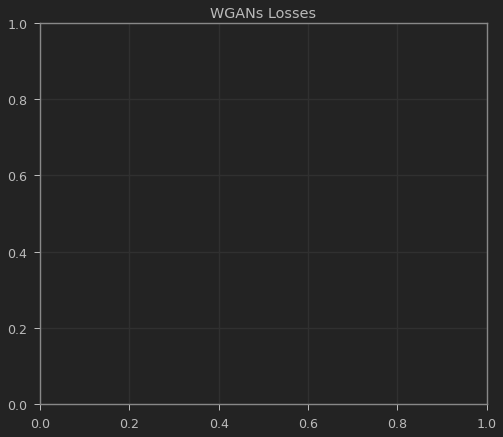

In [ ]:
plt.title("WGANs Losses")
plt.plot(g_losses, label = "Generator Losses")
plt.plot(c_losses, label = "Critic Losses")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()

In [ ]:
G

NameError: ignored